In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
rating_df = pd.read_csv('/content/drive/MyDrive/ratings_Beauty.csv')

In [ ]:
rating_df.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


In [ ]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023070 entries, 0 to 2023069
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   UserId     object 
 1   ProductId  object 
 2   Rating     float64
 3   Timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 61.7+ MB


In [ ]:
rating_df.describe()

,Rating,Timestamp
count,2.023070e+06,2.023070e+06
mean,4.149036e+00,1.360389e+09
std,1.311505e+00,4.611860e+07
min,1.000000e+00,9.087552e+08
25%,4.000000e+00,1.350259e+09
50%,5.000000e+00,1.372810e+09
75%,5.000000e+00,1.391472e+09
max,5.000000e+00,1.406074e+09


In [ ]:
rating_df.isna().sum()

UserId       0
ProductId    0
Rating       0
Timestamp    0
dtype: int64

In [ ]:
review_df = pd.read_json('/content/drive/MyDrive/reviews_Beauty_5.json.gz',lines = True)

In [ ]:
review_df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1YJEY40YUW4SE,7806397051,Andrea,"[3, 4]",Very oily and creamy. Not at all what I expect...,1,Don't waste your money,1391040000,"01 30, 2014"
1,A60XNB876KYML,7806397051,Jessica H.,"[1, 1]",This palette was a decent price and I was look...,3,OK Palette!,1397779200,"04 18, 2014"
2,A3G6XNM240RMWA,7806397051,Karen,"[0, 1]",The texture of this concealer pallet is fantas...,4,great quality,1378425600,"09 6, 2013"
3,A1PQFP6SAJ6D80,7806397051,Norah,"[2, 2]",I really can't tell what exactly this thing is...,2,Do not work on my face,1386460800,"12 8, 2013"
4,A38FVHZTNQ271F,7806397051,Nova Amor,"[0, 0]","It was a little smaller than I expected, but t...",3,It's okay.,1382140800,"10 19, 2013"


In [ ]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198502 entries, 0 to 198501
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   reviewerID      198502 non-null  object
 1   asin            198502 non-null  object
 2   reviewerName    197116 non-null  object
 3   helpful         198502 non-null  object
 4   reviewText      198502 non-null  object
 5   overall         198502 non-null  int64 
 6   summary         198502 non-null  object
 7   unixReviewTime  198502 non-null  int64 
 8   reviewTime      198502 non-null  object
dtypes: int64(2), object(7)
memory usage: 13.6+ MB


In [ ]:
review_df.describe()

,overall,unixReviewTime
count,198502.000000,1.985020e+05
mean,4.190391,1.364450e+09
std,1.166580,3.841937e+07
min,1.000000,1.023840e+09
25%,4.000000,1.354493e+09
50%,5.000000,1.372205e+09
75%,5.000000,1.391213e+09
max,5.000000,1.406074e+09


In [ ]:
review_df.isna().sum()

reviewerID           0
asin                 0
reviewerName      1386
helpful              0
reviewText           0
overall              0
summary              0
unixReviewTime       0
reviewTime           0
dtype: int64

In [ ]:
review_df=review_df.rename(columns={"reviewerID": "UserId", "asin": "ProductId"})
review_rating_df = pd.merge(review_df, rating_df)
review_rating_df.head(5)

,UserId,ProductId,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,Rating,Timestamp
0,A1YJEY40YUW4SE,7806397051,Andrea,"[3, 4]",Very oily and creamy. Not at all what I expect...,1,Don't waste your money,1391040000,"01 30, 2014",1.0,1391040000
1,A60XNB876KYML,7806397051,Jessica H.,"[1, 1]",This palette was a decent price and I was look...,3,OK Palette!,1397779200,"04 18, 2014",3.0,1397779200
2,A3G6XNM240RMWA,7806397051,Karen,"[0, 1]",The texture of this concealer pallet is fantas...,4,great quality,1378425600,"09 6, 2013",4.0,1378425600
3,A1PQFP6SAJ6D80,7806397051,Norah,"[2, 2]",I really can't tell what exactly this thing is...,2,Do not work on my face,1386460800,"12 8, 2013",2.0,1386460800
4,A38FVHZTNQ271F,7806397051,Nova Amor,"[0, 0]","It was a little smaller than I expected, but t...",3,It's okay.,1382140800,"10 19, 2013",3.0,1382140800


In [ ]:
review_rating_df=review_rating_df.drop(['overall','unixReviewTime'],axis=1)
review_rating_df.head(5)

,UserId,ProductId,reviewerName,helpful,reviewText,summary,reviewTime,Rating,Timestamp
0,A1YJEY40YUW4SE,7806397051,Andrea,"[3, 4]",Very oily and creamy. Not at all what I expect...,Don't waste your money,"01 30, 2014",1.0,1391040000
1,A60XNB876KYML,7806397051,Jessica H.,"[1, 1]",This palette was a decent price and I was look...,OK Palette!,"04 18, 2014",3.0,1397779200
2,A3G6XNM240RMWA,7806397051,Karen,"[0, 1]",The texture of this concealer pallet is fantas...,great quality,"09 6, 2013",4.0,1378425600
3,A1PQFP6SAJ6D80,7806397051,Norah,"[2, 2]",I really can't tell what exactly this thing is...,Do not work on my face,"12 8, 2013",2.0,1386460800
4,A38FVHZTNQ271F,7806397051,Nova Amor,"[0, 0]","It was a little smaller than I expected, but t...",It's okay.,"10 19, 2013",3.0,1382140800


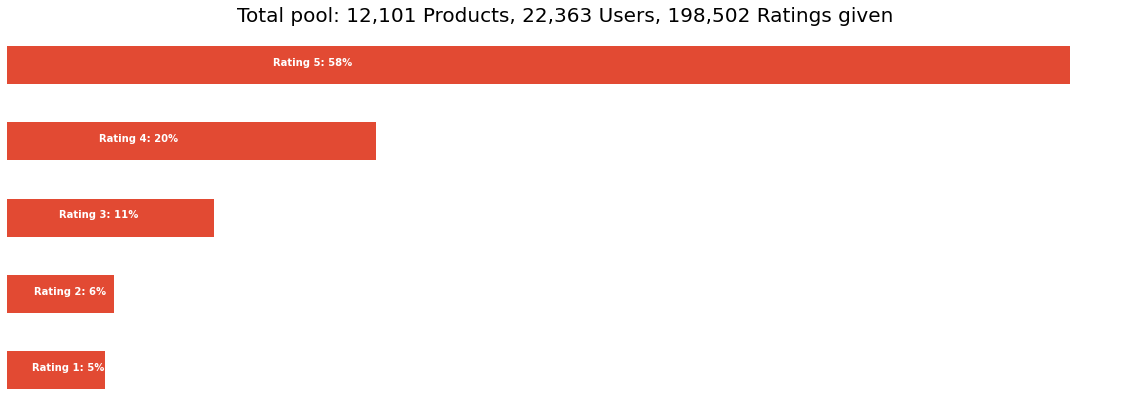

In [ ]:
p = review_rating_df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
products_count = review_rating_df['ProductId'].nunique()
# get customer count
users_count = review_rating_df['UserId'].nunique()
# get rating count
rating_count = review_rating_df['UserId'].count()
#Plottng graph
ax = p.plot(kind = 'barh', legend = False, figsize = (20,7))
plt.title('Total pool: {:,} Products, {:,} Users, {:,} Ratings given'.format(products_count, users_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')


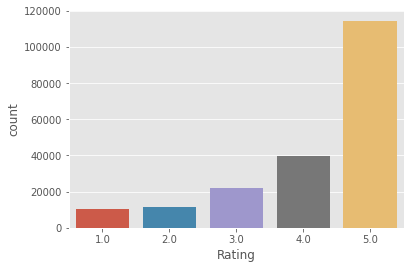

In [ ]:
sns.countplot(x='Rating',data=review_rating_df)

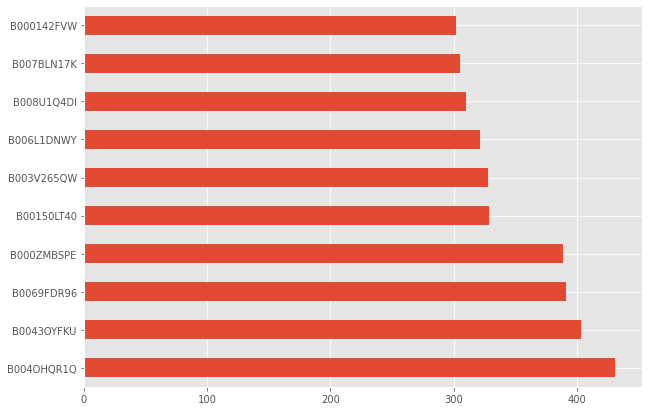

In [ ]:
ax = review_rating_df['ProductId'].value_counts()[:10].plot(kind = 'barh', legend = False, figsize = (10,7))

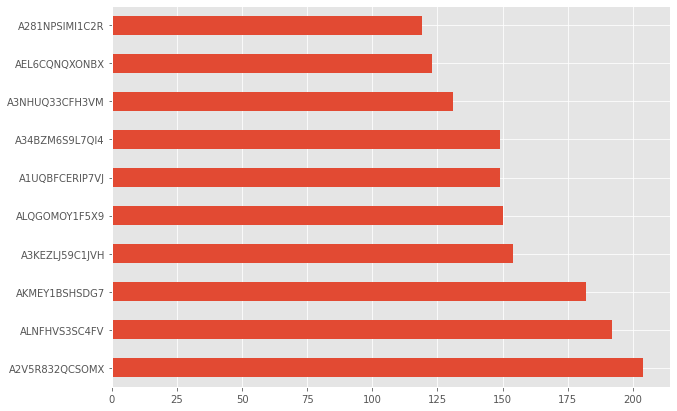

In [ ]:
ax = review_rating_df['UserId'].value_counts()[:10].plot(kind = 'barh', legend = False, figsize = (10,7))

In [ ]:
users_purchase_count_df = review_rating_df.groupby(['UserId', 'ProductId']).size().groupby('UserId').size()
print('No of Unique users: %d' % len(users_purchase_count_df))
print('Number of prurchases: %d' % len(review_rating_df))

No of Unique users: 22363
Number of prurchases: 198502


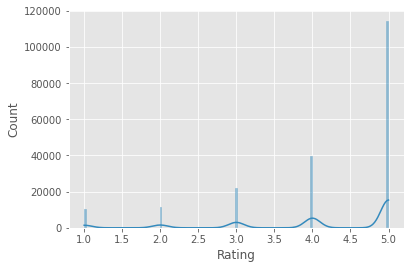

In [ ]:
sns.histplot(review_rating_df.groupby(['UserId', 'ProductId'])['Rating'].sum(),kde=True)

In [ ]:
import math
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
purchase_full_df = review_rating_df.groupby(['UserId', 'ProductId'])['Rating'].sum().apply(smooth_user_preference).reset_index()
print('No of unique user/item purchase: %d' % len(purchase_full_df))
purchase_full_df.head()

No of unique user/item purchase: 198502


,UserId,ProductId,Rating
0,A00414041RD0BXM6WK0GX,B007IY97U0,2.000000
1,A00414041RD0BXM6WK0GX,B00870XLDS,1.584963
2,A00414041RD0BXM6WK0GX,B008MIRO88,1.000000
3,A00414041RD0BXM6WK0GX,B00BQYYMN0,2.000000
4,A00414041RD0BXM6WK0GX,B00GRTQBTM,2.584963


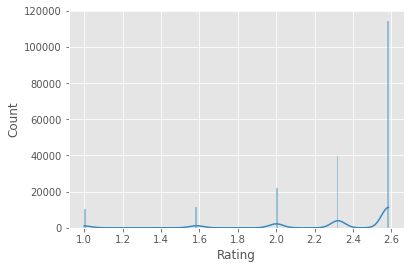

In [ ]:
sns.histplot(purchase_full_df.groupby(['UserId', 'ProductId'])['Rating'].sum(),kde=True)

In [ ]:
from sklearn.model_selection import train_test_split
from IPython.display import Markdown, display
from IPython.display import HTML
def printcd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))
purchase_train_df, purchase_test_df = train_test_split(purchase_full_df,
                                   stratify=purchase_full_df['UserId'], 
                                   test_size=0.20,
                                   random_state=42)
printcd('**Training and Testing Set Distribution**', color='brown')
print(f'Training set has {purchase_train_df.shape[0]} rows and {purchase_train_df.shape[1]} columns')
print(f'Testing set has {purchase_test_df.shape[0]} rows and {purchase_test_df.shape[1]} columns')

<span style='color:brown'>**Training and Testing Set Distribution**</span>

Training set has 158801 rows and 3 columns
Testing set has 39701 rows and 3 columns


In [ ]:
users_products_pivot_matrix_df = purchase_train_df.pivot(index='UserId', 
                                                          columns='ProductId', 
                                                          values='Rating').fillna(0)
users_products_pivot_matrix_df.head()

ProductId,7806397051,9759091062,9788072216,9790790961,9790794231,B00004TMFE,B00004TUBL,B00004TUBV,B00004U9UY,B00004U9V2,B000050B6U,B000052WY7,B000052WYD,B000052WYL,B000052WYN,B000052X9G,B000052XIA,B000052XW5,B000052XYQ,B000052XZP,B000052XZX,B000052Y25,B000052Y33,B000052Y5F,B000052Y6Z,B000052YJC,B000052YJD,B000052YJH,B000052YJM,B000052YJX,B000052YKI,B000052YKM,B000052YKS,B000052YKY,B000052YL1,B000052YLX,B000052YM0,B000052YM3,B000052YM4,B000052YM7,...,B00KFM16OW,B00KGDRCZW,B00KH6F6TM,B00KHGIK54,B00KHH2VOY,B00KI5UL8I,B00KIEGBHE,B00KK1V28I,B00KK62714,B00KKKW03U,B00KLA4INE,B00KLJDYL2,B00KLZO2JE,B00KNIL36E,B00KNJOLSA,B00KPKIV8I,B00KQ4PEBU,B00KQBR9FM,B00KQVTX06,B00KTAJAIY,B00KTLBDYM,B00KTLBEEQ,B00KTP8Q1G,B00KVE7R0Q,B00KVO2JWC,B00KWE08Q0,B00KXG8JF4,B00L0C529Q,B00L2K53BS,B00L2KVF9W,B00L3K91OW,B00L3LB0IG,B00L3LBUGI,B00L5BXG36,B00L5JHZJO,B00L5KTZ0K,B00L6Q3BH6,B00LCEROA2,B00LG63DOM,B00LLPT4HI
UserId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A00414041RD0BXM6WK0GX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A00473363TJ8YSZ3YAGG9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A00700212KB3K0MVESPIY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0078719IR14X3NNUG0F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01198201H0E3GHV2Z17I,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
users_products_pivot_matrix = users_products_pivot_matrix_df.values
users_products_pivot_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
users_ids = list(users_products_pivot_matrix_df.index)
users_ids[:5]

['A00414041RD0BXM6WK0GX',
 'A00473363TJ8YSZ3YAGG9',
 'A00700212KB3K0MVESPIY',
 'A0078719IR14X3NNUG0F',
 'A01198201H0E3GHV2Z17I']

In [ ]:
NUMBER_OF_FACTORS_MF = 35

# Performs matrix factorization of the original user item matrix
U, sigma, VT = svds(users_products_pivot_matrix, k = NUMBER_OF_FACTORS_MF)
users_products_pivot_matrix.shape

(22363, 12101)

In [ ]:
sigma = np.diag(sigma)
sigma.shape
VT.shape

(35, 12101)

In [ ]:
all_usera_predicted_ratings = np.dot(np.dot(U, sigma), VT) 
all_usera_predicted_ratings

array([[ 5.63170637e-05,  5.45958910e-05,  7.71392432e-06, ...,
         7.64366398e-07, -3.41438817e-07, -2.25008274e-05],
       [ 1.81072173e-05,  9.23744538e-05,  1.20901454e-04, ...,
         4.24134813e-06, -1.17100324e-04, -9.59585553e-04],
       [ 7.60701066e-05, -3.37944290e-05,  1.86552573e-04, ...,
         6.50081101e-06, -2.27556472e-04,  8.42125463e-04],
       ...,
       [ 4.52551739e-04, -7.06790097e-04,  4.47610499e-04, ...,
         1.93960494e-06, -2.67174797e-04,  2.94537016e-03],
       [-1.30477608e-05,  2.91898960e-05,  1.02040486e-04, ...,
         8.13548605e-06, -1.50526176e-04, -4.06055512e-04],
       [ 1.56507052e-04,  7.17152547e-05,  1.15210176e-04, ...,
         1.71944892e-05, -2.66837217e-04,  2.44867837e-03]])

In [ ]:
preds_df = pd.DataFrame(all_usera_predicted_ratings, columns = users_products_pivot_matrix_df.columns, index=users_ids).transpose()
preds_df.head()

,A00414041RD0BXM6WK0GX,A00473363TJ8YSZ3YAGG9,A00700212KB3K0MVESPIY,A0078719IR14X3NNUG0F,A01198201H0E3GHV2Z17I,A02155413BVL8D0G7X6DN,A02849582PREZYNEI31CV,A029527620Q3SK5XW16RR,A03236882LUP4ARMDDMXU,A03364251DGXSGA9PSR99,A0388397363MZHRU6ALSX,A042274212BJJVOBS4Q85,A04371222UWPCRS81JO2Z,A0459829SI5B5WIOZZHX,A0508779FEO1DUNOSQNX,A05306962T0DL4FS2RA7L,A059547920Q3LZVFHLPI3,A0614215ICIJ7IVV472R,A06298653TJ91G7R7MD6R,A0647567NOSE5H95OBQ2,A06586901ZOUBJS3R268N,A0733801U845JJGV4H8V,A07420391OVT9BFTVMUOI,A08409921GVN7C8RD97CV,A0864963DOAY7LXGS5I6,A090214335ZYBWI945UJI,A0908131Z7BWYSMRQ16T,A09149312G3TQJJF59GC8,A09386383518NVR7RSA4F,A099766128UI0NCS98N1E,A100E9O4Z9BP4Q,A100L918633LUO,A100LIFNJYZWW7,A100UD67AHFODS,A100VQNP6I54HS,A100WO06OQR8BQ,A100X30Z2GCTEM,A100ZQDV7L8PVV,A1010QRG4BH51B,A101E37WFPUEII,...,AZRPMQ8A4H0W4,AZS23E3IKSF9D,AZS4UNYSAZVG8,AZS5TOKUYLDO0,AZS9WNWY48XF5,AZSWYOYUCD81E,AZTYMMD36CXY2,AZTZ7SIIRXLXE,AZU2UCJP6WUQO,AZUEKJ6P9TFSJ,AZUH2MX87LX7J,AZUH5XSJ2NLXR,AZUPWQFWXZYE9,AZV2AG96CRJ26,AZV7CNMMJERKW,AZVM27SJPO3GL,AZW9UD7Z7J0WL,AZWJAXOQMB8EK,AZWXG6KBXXC2N,AZWZF1F7QCPSE,AZX1JTTIUYZX4,AZX5U35YDZZXI,AZXH0JC9KOLU8,AZXP46IB63PU8,AZY3Z9QI0G8L,AZY8RW6L7W52Z,AZYA6NBTF2843,AZYAFW3CRARM6,AZYH32578YZBF,AZYN9RRLZUNVA,AZYNK58DULI59,AZYVVBYSD74KP,AZZ5ASC403N74,AZZ91VNEU3XYX,AZZIOU48NE8PC,AZZNK89PXD006,AZZQXL8VDCFTV,AZZT1ERHBSNQ8,AZZU6NXB8YJN9,AZZZLM1E5JJ8C
ProductId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7806397051,0.000056,0.000018,0.000076,-0.000218,-0.000807,-0.000016,0.000711,-0.000190,-0.000524,0.002148,0.000107,0.000083,0.000040,0.000080,0.000329,0.000347,0.001176,0.000048,0.000095,0.000131,0.000006,0.000168,0.000072,0.000019,0.000399,0.000489,-0.000113,0.000065,0.000648,0.000903,0.000814,0.000021,0.000072,0.000010,0.000240,0.001125,-0.000009,-0.000132,-0.000477,-0.000076,...,-0.000560,0.000057,0.000365,0.000086,0.001667,0.000010,0.000119,0.000047,0.000144,-0.000054,-0.000220,0.000131,0.000152,0.000445,-0.000425,-0.000073,0.000051,0.000162,0.000047,-0.000002,0.000117,0.000058,0.000008,-0.000183,0.000095,0.000266,0.000202,-0.000115,0.000046,0.000823,2.122282e-05,0.000064,-0.000166,0.000046,0.000036,0.000019,0.000255,0.000453,-0.000013,0.000157
9759091062,0.000055,0.000092,-0.000034,-0.000336,-0.000190,-0.000063,-0.000194,-0.000228,-0.000049,-0.000943,0.000084,0.000167,-0.000032,0.000111,0.000128,0.000170,0.000623,0.000031,0.000076,0.000154,0.000049,-0.000266,0.000043,-0.000013,0.000804,0.000903,-0.000075,-0.000007,0.000269,0.000853,0.001216,0.000035,0.000089,0.000006,0.000349,0.003333,0.000036,-0.000203,-0.001274,0.000093,...,-0.000074,-0.000042,0.000288,0.000022,0.000486,-0.000015,0.000126,0.000071,-0.000150,-0.000004,0.000030,-0.000140,-0.000075,0.000450,-0.000029,-0.000083,-0.000009,-0.000021,0.000077,-0.000016,-0.000053,-0.000015,0.000009,-0.000515,0.000154,0.000472,0.000206,0.000010,0.000030,-0.000267,-5.168876e-07,-0.000051,0.000121,-0.000056,-0.000049,-0.000015,-0.000089,-0.000707,0.000029,0.000072
9788072216,0.000008,0.000121,0.000187,0.000046,0.000138,-0.000004,0.000053,0.000155,0.000205,0.001621,0.000041,0.000142,0.000016,0.000163,0.000369,0.000694,0.000326,0.000035,0.000038,0.000183,0.000371,0.000638,0.000054,0.000022,0.000107,0.000182,0.000089,0.000150,0.000267,0.000500,0.000293,0.000050,0.000038,0.000032,0.000618,-0.000659,-0.000006,0.000284,-0.000274,0.000050,...,0.000171,0.000091,0.000103,0.000366,0.000166,0.000041,0.000068,0.000198,0.000057,0.000129,-0.000092,0.000153,-0.000158,0.000150,-0.000045,0.000132,0.000097,0.000143,0.000105,0.000029,0.000105,0.000062,0.000033,0.001114,0.000086,0.000168,0.000131,-0.000021,0.000042,0.000383,1.671252e-05,0.000264,0.000088,0.000072,0.000011,0.000028,0.000258,0.000448,0.000102,0.000115
9790790961,0.000222,0.000351,-0.000056,0.012612,0.004910,-0.000123,0.003826,-0.001002,-0.001617,0.004094,0.000237,-0.000001,0.000433,0.000059,0.001295,-0.000339,0.004445,0.000082,0.000251,0.000679,0.000914,0.002261,0.000618,0.000036,0.000914,0.001026,0.000009,

In [ ]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df):
        self.cf_predictions_df = cf_predictions_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False).reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating content that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['ProductId'].isin(items_to_ignore)].sort_values('recStrength', ascending = False).head(topn)

        return recommendations_df


cf_recommender_model = CFRecommender(preds_df)

In [ ]:
purchases_full_indexed_df = purchase_full_df.set_index('UserId')
purchases_train_indexed_df = purchase_train_df.set_index('UserId')
purchases_test_indexed_df = purchase_test_df.set_index('UserId')

In [ ]:
def get_product_purchased(UserId, review_rating_df):
    purchased_product = review_rating_df.loc[UserId]['ProductId']
    return set(purchased_product if type(purchased_product) == pd.Series else [purchased_product])
import random
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:

    # Function for getting the set of items which a user has not interacted with
    def get_not_purchased_products_sample(self, UserId, sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, seed=42):
        purchased_products = get_product_purchased(UserId, purchases_full_indexed_df)
        all_products = set(review_rating_df['ProductId'])
        non_purchased_products = all_products - purchased_products

        random.seed(seed)
        non_purchased_products_sample = random.sample(non_purchased_products, sample_size)
        return set(non_purchased_products_sample)

    # Function to verify whether a particular item_id was present in the set of top N recommended items
    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index
    
    # Function to evaluate the performance of model for each user
    def evaluate_model_for_user(self, model, person_id):
        
        # Getting the items in test set
        purchased_values_testset = purchases_test_indexed_df.loc[person_id]
        
        if type(purchased_values_testset['ProductId']) == pd.Series:
            users_purchased_products_testset = set(purchased_values_testset['ProductId'])
        else:
            users_purchased_products_testset = set([(purchased_values_testset['ProductId'])])
            
        purchased_products_count_testset = len(users_purchased_products_testset) 

        # Getting a ranked recommendation list from the model for a given user
        person_recs_df = model.recommend_items(person_id, items_to_ignore=get_product_purchased(person_id, purchases_train_indexed_df),topn=10000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        hits_at_15_count = 0
        
        # For each item the user has interacted in test set
        for item_id in users_purchased_products_testset:
            
            # Getting a random sample of 100 items the user has not interacted with
            non_purchased_products_sample = self.get_not_purchased_products_sample(person_id,seed=item_id)

            # Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_purchased_products_sample.union(set([item_id]))

            # Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['ProductId'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['ProductId'].values
            
            # Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10
            hit_at_15, index_at_15 = self._verify_hit_top_n(item_id, valid_recs, 15)
            hits_at_15_count += hit_at_15

        # Recall is the rate of the interacted items that are ranked among the Top-N recommended items
        recall_at_5 = hits_at_5_count / float(purchased_products_count_testset)
        recall_at_10 = hits_at_10_count / float(purchased_products_count_testset)
        recall_at_15 = hits_at_15_count / float(purchased_products_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'hits@15_count':hits_at_15_count,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10,
                          'recall@15': recall_at_15,
                          'interacted_count': purchased_products_count_testset}
        return person_metrics

    
    # Function to evaluate the performance of model at overall level
    def evaluate_model(self, model):
        
        people_metrics = []
        
        for idx, person_id in enumerate(list(purchases_test_indexed_df.index.unique().values)):    
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['UserId'] = person_id
            people_metrics.append(person_metrics)
            
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics).sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_15 = detailed_results_df['hits@15_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10,
                          'recall@15': global_recall_at_15}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()



In [ ]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
22362 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.38266038638825217, 'recall@10': 0.4754540187904587, 'recall@15': 0.5362081559658447}


,hits@5_count,hits@10_count,hits@15_count,recall@5,recall@10,recall@15,interacted_count,UserId
1263,6,12,13,0.146341,0.292683,0.317073,41,A2V5R832QCSOMX
1094,34,36,36,0.871795,0.923077,0.923077,39,ALNFHVS3SC4FV
210,14,22,23,0.378378,0.594595,0.621622,37,AKMEY1BSHSDG7
1989,5,9,11,0.161290,0.290323,0.354839,31,A3KEZLJ59C1JVH
1711,17,18,18,0.566667,0.600000,0.600000,30,A34BZM6S9L7QI4
197,2,7,10,0.066667,0.233333,0.333333,30,ALQGOMOY1F5X9
992,26,29,29,0.866667,0.966667,0.966667,30,A1UQBFCERIP7VJ
137,23,23,24,0.884615,0.884615,0.923077,26,A3NHUQ33CFH3VM
545,22,22,22,0.880000,0.880000,0.880000,25,AEL6CQNQXONBX
1761,5,8,9,0.208333,0.333333,0.375000,24,A281NPSIMI1C2R


In [ ]:
purchases_full_indexed_df = purchase_full_df.set_index('UserId')
purchases_train_indexed_df = purchase_train_df.set_index('UserId')
purchases_test_indexed_df = purchase_test_df.set_index('UserId')

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import string
from nltk.corpus import stopwords
#Ignoring stopwords (words with no semantics) from English and Portuguese (as we have a corpus with mixed languages)
stopwords_list = stopwords.words('english')

#Trains a model whose vectors size is 5000, composed by the main unigrams and bigrams found in the corpus, ignoring stopwords
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=3000,
                     stop_words=stopwords_list)

item_ids = review_rating_df['ProductId'].tolist()
tfidf_matrix = vectorizer.fit_transform(review_rating_df['reviewText'] + "" + review_rating_df['summary'])
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix

<198502x2366 sparse matrix of type '<class 'numpy.float64'>'
	with 6780848 stored elements in Compressed Sparse Row format>

In [ ]:
stopwords_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
tfidf_feature_names

['00',
 '10',
 '10 minutes',
 '100',
 '11',
 '12',
 '13',
 '14',
 '15',
 '15 minutes',
 '16',
 '20',
 '20 minutes',
 '24',
 '25',
 '2nd',
 '30',
 '30 minutes',
 '34',
 '40',
 '45',
 '50',
 '60',
 '8217',
 '99',
 'able',
 'able use',
 'absolute',
 'absolutely',
 'absolutely love',
 'absorb',
 'absorbed',
 'absorbs',
 'absorbs quickly',
 'accidentally',
 'achieve',
 'acid',
 'acne',
 'acne prone',
 'across',
 'acrylic',
 'active',
 'actual',
 'actually',
 'add',
 'added',
 'adding',
 'addition',
 'additional',
 'adds',
 'admit',
 'adult',
 'advertised',
 'affordable',
 'afraid',
 'african',
 'african american',
 'afterwards',
 'age',
 'aging',
 'ago',
 'agree',
 'air',
 'air dry',
 'alcohol',
 'allergic',
 'allergies',
 'allow',
 'allows',
 'almond',
 'almost',
 'almost like',
 'aloe',
 'alone',
 'along',
 'alot',
 'already',
 'also',
 'also great',
 'also like',
 'also love',
 'also use',
 'also used',
 'alternative',
 'although',
 'always',
 'always use',
 'amazed',
 'amazing',
 'amazi

In [ ]:
from scipy.sparse import vstack
from sklearn.preprocessing import normalize
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile
def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = vstack(item_profiles_list)
    return item_profiles
def build_users_profile(user_id, purchased_indexed_df):
    purchases_user_df = purchased_indexed_df.loc[user_id]
    user_product_profiles = get_item_profiles(purchases_user_df['ProductId'])
    
    user_product_strengths = np.array(purchases_user_df['Rating']).reshape(-1,1)
    
    # Weighted average of item profiles by the interactions strength
    user_product_strengths_weighted_avg = np.sum(user_product_profiles.multiply(user_product_strengths), axis=0) / np.sum(user_product_strengths)
    user_profile_norm = normalize(user_product_strengths_weighted_avg)
    return user_profile_norm
def build_users_profiles(): 
    purchased_indexed_df = purchase_full_df[purchase_full_df['ProductId'].isin(review_rating_df['ProductId'])].set_index('UserId')
    user_profiles = {}
    for user_id in purchased_indexed_df.index.unique():
        user_profiles[user_id] = build_users_profile(user_id, purchased_indexed_df)
    return user_profiles
user_profiles = build_users_profiles()
len(user_profiles)

22363

In [ ]:
user_profile = user_profiles['A00414041RD0BXM6WK0GX']
print(user_profile.shape)

# Making A DataFrame to store the result...
pd.DataFrame(sorted(zip(tfidf_feature_names,user_profiles['A00414041RD0BXM6WK0GX'].flatten().tolist()), key=lambda x: -x[1])[:20],columns=['token', 'relevance'])

(1, 2366)


,token,relevance
0,wig,0.715549
1,head,0.286604
2,fit,0.170562
3,average,0.140115
4,cap,0.139048
5,entire,0.123835
6,come,0.121345
7,hair,0.114995
8,fabulous,0.114200
9,mention,0.113886


In [ ]:
import random
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, products_df=None):
        self.item_ids = item_ids
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_products_to_user_profile(self, person_id, topn=1000):
        
        # Compute the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
        
        # Get the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        
        # Sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10):
        similar_items = self._get_similar_products_to_user_profile(user_id)
        
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['ProductId', 'recStrength']).head(topn)



        return recommendations_df
    
content_based_recommender_model = ContentBasedRecommender()

In [ ]:
def get_product_purchased(person_id, purchases_df):
    purchased_product = purchases_df.loc[person_id]['ProductId']
    return set(purchased_product if type(purchased_product) == pd.Series else [purchased_product])

In [ ]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:

    # Function for getting the set of products which a user has not purchased with
    def get_not_purchased_products_sample(self, UserId, sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, seed=42):
        purchased_products = get_product_purchased(UserId, purchases_full_indexed_df)
        all_products = set(review_rating_df['ProductId'])
        non_purchased_products = all_products - purchased_products

        random.seed(seed)
        non_purchased_products_sample = random.sample(non_purchased_products, sample_size)
        return set(non_purchased_products_sample)

    # Function to verify whether a particular product_id was present in the set of top N recommended products
    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index
    
    # Function to evaluate the performance of model for each user
    def evaluate_model_for_user(self, model, person_id):
        
        # Getting the items in test set
        purchased_values_testset = purchases_test_indexed_df.loc[person_id]
        
        if type(purchased_values_testset['ProductId']) == pd.Series:
            users_purchased_products_testset = set(purchased_values_testset['ProductId'])
        else:
            users_purchased_products_testset = set([(purchased_values_testset['ProductId'])])
            
        purchased_products_count_testset = len(users_purchased_products_testset)  

        # Getting a ranked recommendation list from the model for a given user
        person_recs_df = model.recommend_items(person_id, items_to_ignore=get_product_purchased(person_id, purchases_train_indexed_df),topn=10000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        hits_at_15_count = 0
        
        # For each product the user has purchased in test set
        for item_id in users_purchased_products_testset:
            
            # Getting a random sample of 100 products the user has not purchased with
            non_purchased_products_sample = self.get_not_purchased_products_sample(person_id,seed=item_id)

            # Combining the current purchased product with the 100 random items
            items_to_filter_recs = non_purchased_products_sample.union(set([item_id]))

            # Filtering only recommendations that are either the purchased product or from a random sample of 100 non-purchased product
            valid_recs_df = person_recs_df[person_recs_df['ProductId'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['ProductId'].values
            
            # Verifying if the current purchased product is among the Top-N recommended products
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10
            hit_at_15, index_at_15 = self._verify_hit_top_n(item_id, valid_recs, 15)
            hits_at_15_count += hit_at_15

        # Recall is the rate of the interacted items that are ranked among the Top-N recommended items
        recall_at_5 = hits_at_5_count / float(purchased_products_count_testset)
        recall_at_10 = hits_at_10_count / float(purchased_products_count_testset)
        recall_at_15 = hits_at_15_count / float(purchased_products_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'hits@15_count':hits_at_15_count,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10,
                          'recall@15': recall_at_15,
                          'interacted_count': purchased_products_count_testset}
        return person_metrics

    # Function to evaluate the performance of model at overall level
    def evaluate_model(self, model):
        
        people_metrics = []
        
        for idx, person_id in enumerate(list(purchases_test_indexed_df.index.unique().values)):    
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['UserId'] = person_id
            people_metrics.append(person_metrics)
            
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics).sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_15 = detailed_results_df['hits@15_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10,
                          'recall@15': global_recall_at_15}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()


In [ ]:
print('Evaluating Content-Based Filtering model...')
cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(content_based_recommender_model)
print('\nGlobal metrics:\n%s' % cb_global_metrics)
cb_detailed_results_df.head(5)
cb_detailed_results_df.tail(5)

Evaluating Content-Based Filtering model...
22362 users processed

Global metrics:
{'modelName': 'Content-Based', 'recall@5': 0.8384675448981134, 'recall@10': 0.8629505554016271, 'recall@15': 0.868466789249641}


,hits@5_count,hits@10_count,hits@15_count,recall@5,recall@10,recall@15,interacted_count,UserId
10717,1,1,1,1.0,1.0,1.0,1,A2CMHND1J2REXO
10718,1,1,1,1.0,1.0,1.0,1,AT9IIRZG9EA
10719,1,1,1,1.0,1.0,1.0,1,A9V313DO1PZTF
10720,1,1,1,1.0,1.0,1.0,1,A18I3C6E5VKADI
22362,1,1,1,1.0,1.0,1.0,1,A3U46FFN9OP7BL
